### Many-body Entanglement and Tensor Networks
Tutorials based on the 2017 Perimeter Scholar International Condensed Matter Review course taught by Guifre Vidal

# <span style="color:#0C45A9">Python tutorial 3</span>

In this tutorial we will obtain universal conformal field theory data from our quantum Ising spin chain model. We will observe finite size effects which originate from the numerical simulation, and would fade as $N\to\infty$. <br>
We will do this by **simultaneously diagonalising** $H,T,S$: the Hamiltonian ($H$), the translation operator ($T$) and the spin flip operator ($S$), since they are symmetries of the sytem:<br>
<br>
<center> $H \left\vert \psi_{\alpha} \right \rangle = E_{\alpha}\left\vert \psi_{\alpha} \right \rangle  $ <center> 
    <br>
<center> $T \left\vert \psi_{\alpha} \right \rangle = e^{ik_{\alpha}}\left\vert \psi_{\alpha} \right \rangle  $ <center>
    <br>
<center> $S \left\vert \psi_{\alpha} \right \rangle = (-1)^{p_{\alpha}}\left\vert \psi_{\alpha} \right \rangle  $ <center> <br>
    
From the diagonalisation , we can get $E_{\alpha}$, $k_{\alpha}$ and. $p_{\alpha}$ from: <br>
<center> $ E_{\alpha} = \left \langle  \psi_{\alpha} \right \vert H \left\vert \psi_{\alpha} \right \rangle $<center>
<br>
<center> $ e^{ik_{\alpha}} = \left \langle  \psi_{\alpha} \right \vert T \left\vert \psi_{\alpha} \right \rangle \; \to \; k_{\alpha}= \text{angle}\left( \left \langle  \psi_{\alpha} \right \vert T \left\vert \psi_{\alpha} \right \rangle\right) $ <center>
<br>
<center> $ p_{\alpha} = \frac{1-\left \langle  \psi_{\alpha} \right \vert S \left\vert \psi_{\alpha} \right \rangle }{2} $ <center>
 <br>
    
Finally, we can get the CFT **scaling dimension** ($\Delta_{\alpha}$) and **conformal spin** ($S_{\alpha}$): <br>
<br>
<center> $ E_{\alpha} = A + \frac{B}{N}\left(\Delta_{\alpha}-\frac{c}{12} \right) + \mathcal{O}\left(\frac{1}{N^2}\right)  \quad\quad \to  \quad\quad E_{\alpha} - E_0 = \frac{B}{N}(\Delta_{\alpha}-\Delta_0)$<center>   
    <br>
    <center> $ k_{\alpha} = \frac{2\pi}{N}S_{\alpha} \quad\quad \to \quad\quad \boxed{S_{\alpha} = \frac{N}{2\pi}k_{\alpha}}$  <center>    
 <br>
 <p align="left"> where we know $\Delta_0 = 0$ and $\Delta_1=1/8$.<br>
 However, we still don't know $B$ but we can use the relation:
 <center> $\frac{E_{\alpha}-E_0}{E_1-E_0}=\frac{\Delta_{\alpha}-\Delta_0}{\Delta_1-\Delta_0}=\frac{\Delta_{\alpha}}{\Delta_1}=8\Delta_{\alpha} \quad \to \quad \boxed{\Delta_{\alpha} = \frac{1}{8}\frac{E_{\alpha}-E_0}{E_1-E_0}}$. <br>
 In this notebook we won't fully diagonalise our matrices, but we will use spa

## 3.1. Conformal field theory (CFT) data for PBC quantum Ising model on $N$ spins

Define the Hamiltonian for the quantum Ising model as per the previous tutorial.

In [1]:
import numpy as np

def qIsingH(N, h, bc = 1): #bc = 1 PBC, =-1 APBC
    I = np.eye(2) #2x2 identity matrix
    X = np.array([[0,1],[1,0]]) #Pauli-X
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    XX = np.kron(X,X) 
    H = -XX - h*(np.kron(Z,I) + np.kron(I,Z)) #Hamiltonian for N=2
    
    for n in range(3,(N+1)):
        H = np.kron(H,I)-np.kron(np.eye(2**(n-2)),XX)-h*np.kron(np.eye(2**(n-1)),Z)

    H = H - bc*np.kron(X,np.kron(np.eye(2**(N-2)),X))
    
    return H

### 3.1.1. Translation and parity operators: symmetries

#### Translation operator, $T$

Define the translator operator $T$ which acts by mapping spin $m \to m+1$ such that $T\left\vert s_1 s_2 s_3 \right \rangle = \left\vert s_3 s_1 s_2 \right \rangle$ and $T\,\sigma_m^{\alpha}\, T^{\dagger}= \sigma_{m=1}^{\alpha}$. Our Hamiltonian is invariant under translations: $[H,T] = 0$. We also know that momentum is the generator of translations: $T \to P_{\alpha}$ <br>
We will build this operator from the _SWAP_ operator on $N=2$. The _SWAP_ operator acts on two spins the following way: $SWAP\left\vert s_1 s_2 \right \rangle = \left\vert s_2 s_1 \right \rangle$.

In [2]:
def T_op(N):
    SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) #SWAP operator
    I = np.eye(2)
    T = SWAP
    SWAP_N = SWAP #SWAP for N spins that we will build
    
    for n in range(3,(N+1)):
        T = np.kron(T,I)
        SWAP_N = np.kron(I, SWAP_N)
        T = T.dot(SWAP_N)
        
    return T

#### Spin flip operator, $S$

This operator applies the Pauli-$Z$ operator to all the qubits: $S = \sigma_1^z \otimes \sigma_2^z \otimes \cdots \otimes \sigma_N^z$.

In [3]:
def S_op(N):
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    Z_2 = Z

    for n in range(2,(N+1)):
        Z_2 = np.kron(Z_2,Z)
        
    P = Z_2
    return P

### 3.1.1. Define Hamiltonian

We want to simulatenously diagonalise $H,T$ and $S$, so we consider $H = H+\alpha HT + \beta HS$. We choose $\alpha$ and $\beta$ such that the scales of the entries of $H$, $HT$ and $HS$ are very different. 
<br>Note that $T$ is non-hermitian, so eigenvalues can be complex.

In [4]:
N = 10 #Hamiltonian will be 2^N x 2^N
h = 1

H_TFIM = qIsingH(N,h) #PBC quantum Ising
H_TFIM -= 4*N*np.eye(2**N) #make all eigenvalues negative
T = T_op(N)
S = S_op(N)

H_final = H_TFIM.dot(np.eye(2**N) + 0.001*T +0.00001*S)

### 3.1.2. Sparse diagonalisation method: largest eigenvalues

We obtain only the _num_states_ eigenvectors with smallest energy eigenvalues. This is done by using a Fortran package called _ARPACK_, which provides routines for quickly finding a few eigenvalues/eigenvectors of large sparse matrices. All of the functionality provided in _ARPACK_ is contained within the high-level interface _scipy.sparse.linalg.eigs_.

In [5]:
from scipy.sparse.linalg import eigs

num_states = 12

D, Psi = eigs(H_final, k = num_states, which = 'LM')

### 3.1.3. Obtain $E_{\alpha}$, $k_{\alpha}$, $p_{\alpha}$

Evaluate the energy $E$, momentum $k$ and parity $p$ on the obtained eigenvectors. 

In [7]:
E = np.real(np.diag((Psi.conj().T).dot(H_TFIM).dot(Psi))) + 4*N #shift back
k = np.angle(np.diag((Psi.conj().T).dot(T).dot(Psi)))
p = np.diag((Psi.conj().T).dot(S).dot(Psi))
p = abs(np.real(((1-p)/2).round()))

#sort from smaller to largest
ord_idx = np.argsort(E)
E = E[ord_idx]
k = k[ord_idx] 
p = p[ord_idx]

#remove degeneracies 
#E, unique_ix = np.unique(E, return_index=True)
#k = k[unique_ix] 
#p = p[unique_ix]'''

In [8]:
print('Energy: %s \nMomentum: %s \nParity: %s\n' %(E,k,p))
E_unique = np.unique(E)
print("Unique number of eigenvalues: %s / %s" %(len(E_unique), len(E)))

Energy: [-12.78490644 -12.62750303 -11.53343072 -11.39143505 -11.39143505
 -10.34320658 -10.34320658 -10.34320658 -10.34320658 -10.27636202
 -10.27636202 -10.15536707] 
Momentum: [ 0.          0.          0.         -0.62831853  0.62831853 -1.25663706
  1.25663706 -0.62831853  0.62831853 -1.25663706  1.25663706  0.        ] 
Parity: [0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]

Unique number of eigenvalues: 8 / 12


### 3.1.4. Numerical estimates of $\Delta_{\alpha}$ and $S_{\alpha}$

In [9]:
scaling_dim = (1/8)*(E-E[0])/(E[1]-E[0])
conf_spin = k/(2*np.pi)*N

In [10]:
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim, conf_spin))

Scaling dimension: [0.         0.125      0.99384417 1.1066083  1.1066083  1.93904614
 1.93904614 1.93904614 1.93904614 1.99212994 1.99212994 2.0882166 ] 
Conformal spin: [ 0.  0.  0. -1.  1. -2.  2. -1.  1. -2.  2.  0.]


### 3.1.5. Plot theory vs numerical CFT data comparison

In [11]:
th_scaling_dim = [0, 1/8, 1, 1+1/8, 1+1/8, 2, 2, 2, 2, 2+1/8, 2+1/8, 2+1/8]
th_parity = [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]
th_conf_spin = [0,  0,  0,  -1, 1,  -1, 1,  -2,  2,  -2,  2,  0]

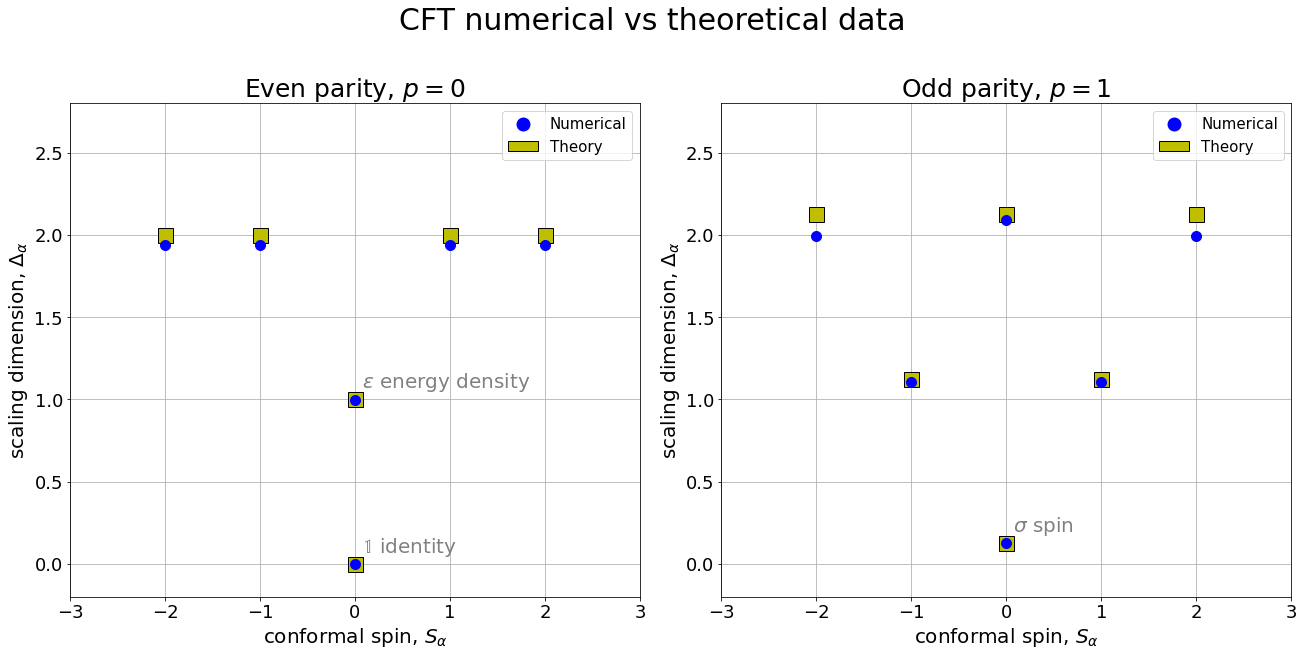

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(18, 9))
fig.suptitle('CFT numerical vs theoretical data\n', fontsize=30)
ax1.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax2.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax1.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax2.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax1.set_title(r'Even parity, $p=0$', fontsize=25)
ax2.set_title(r'Odd parity, $p=1$', fontsize=25)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.grid()
ax2.grid()
ax1.set_xlim([-3, 3])
ax2.set_xlim([-3, 3])
ax1.set_ylim([-0.2, 2.8])
ax2.set_ylim([-0.2, 2.8])
ax1.text(0.07,1.07,r"$\epsilon$ energy density", fontsize=20, color='grey')
ax1.text(0.07,0.07,r"$\mathbb{1}$ identity", fontsize=20, color='grey')
ax2.text(0.07,1/8+0.07,r"$\sigma$ spin", fontsize=20, color='grey')

for i in range(len(th_parity)):
    if th_parity[i] == 0:
        ax1.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)
    elif th_parity[i] == 1:
        ax2.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)


for i in range(num_states):
    if p[i] == 0:
        ax1.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)
    elif p[i] == 1:
        ax2.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Numerical',
                          markerfacecolor='b', markersize=15),
                   Patch(facecolor='y', edgecolor='black',
                         label='Theory')]

        
ax1.legend(handles=legend_elements, fontsize=15)
ax2.legend(handles=legend_elements, fontsize=15)


## 3.2. Conformal field theory (CFT) data for APBC quantum Ising model on $N$ spins

### 3.1.1. Define Hamiltonians